# 11_A_Experiment_3_Preprocessing

## This is the primary file to pre-analyze the data for Experiment 3 and adjust labels files.
File 11_B_Experiment_3_Train is the is the script for training the models for experiment 3 and 11_C_Experiment_3_Test is the script for evaluating the performance of the trained models on the respective test sets. Training and testing were split up between different scripts to allow for parallel computing. 

Some parts of the plotting functions were adapted from chatGPT.

In [6]:
!pip install geopandas
!pip install latex

In [94]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import latex
import glob

In [95]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-v0_8-colorblind")

## Number of towers per size in train/val/test

In [11]:
base_path = "/workspace/data"

os.chdir(base_path)

jf = open("labels_tower_train.json")
labels_train = json.load(jf)


jf = open("labels_tower_val.json")
labels_val = json.load(jf)

jf = open("labels_tower_test.json")
labels_test = json.load(jf)

In [12]:
unique_train = []
unique_val = []
unique_test = []

for i in labels_train['annotations']:
    if i not in unique_train:
        unique_train.append(i)
        
for i in labels_val['annotations']:
    if i not in unique_val:
        unique_val.append(i)
        
unique_test = []
for i in labels_test['annotations']:
    if i not in unique_test:
        unique_test.append(i)


sizes_train = np.asarray([i['bbox'][2:4] for i in unique_train])
sizes_val = np.asarray([i['bbox'][2:4] for i in unique_val])
sizes_test = np.asarray([i['bbox'][2:4] for i in unique_test])

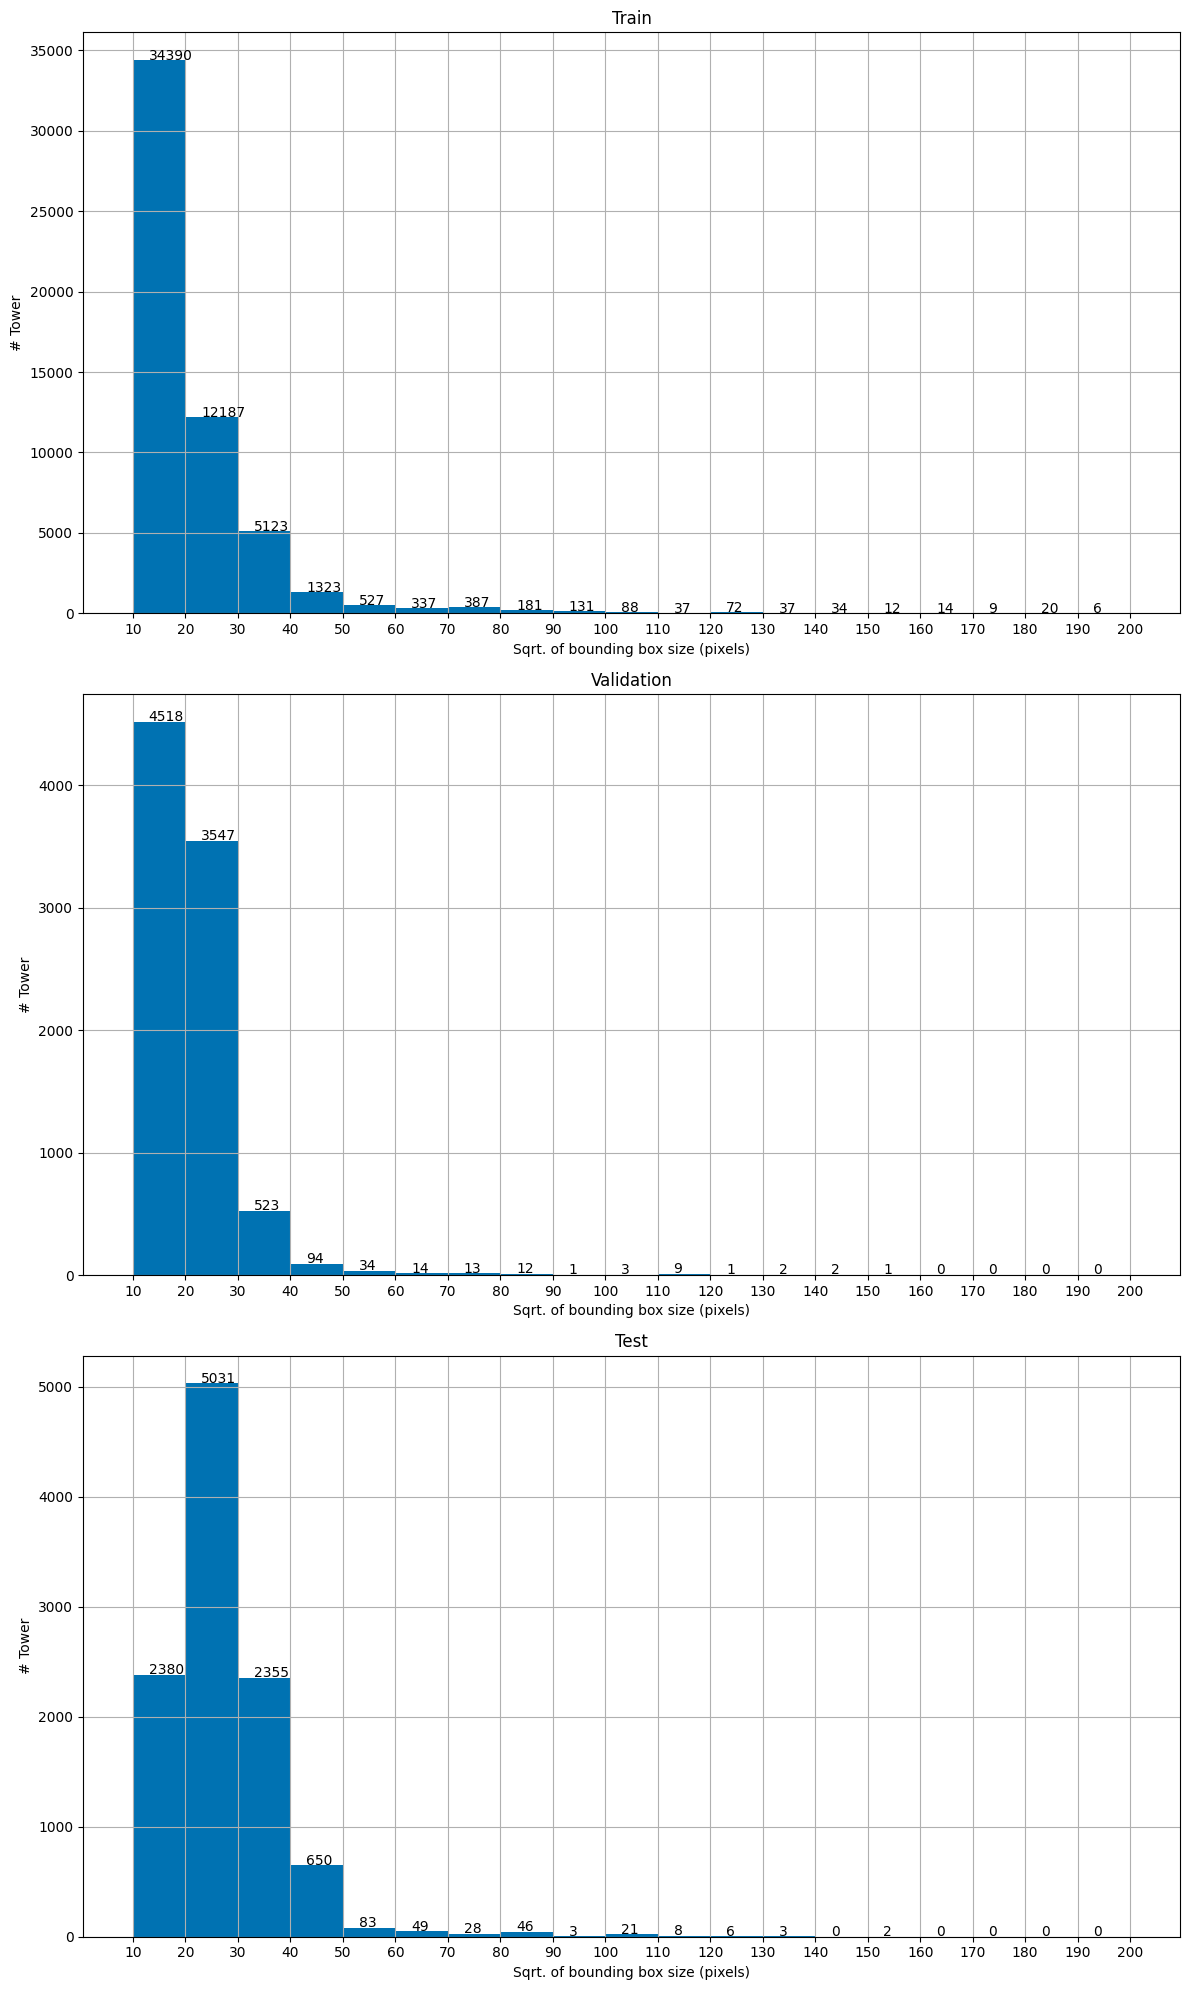

In [18]:
import math

fig, axs = plt.subplots(3, 1, figsize=(12, 20))

# Train subplot
train_counts, train_bins, _ = axs[0].hist([(i**.5) for i in (sizes_train[:,0]*sizes_train[:,1])], bins=[10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200], label='Train')

axs[0].set_xticks([10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
axs[0].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[0].set_ylabel('# Tower')
axs[0].set_title('Train')
axs[0].grid()

for i in range(len(train_counts)):
    axs[0].text(train_bins[i] + 3, train_counts[i] + 5, int(train_counts[i]), fontsize=10, color='black')


# Validation subplot
val_counts, val_bins, _ = axs[1].hist([(i**.5) for i in (sizes_val[:,0]*sizes_val[:,1])], bins=[10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200], label='Validation')
axs[1].set_xticks([10,20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
axs[1].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[1].set_ylabel('# Tower')
axs[1].set_title('Validation')
axs[1].grid()

for i in range(len(val_counts)):
    axs[1].text(val_bins[i] + 3, val_counts[i] + 5, int(val_counts[i]), fontsize=10, color='black')


# Test subplot
test_counts, test_bins, _ = axs[2].hist([(i**.5) for i in (sizes_test[:,0]*sizes_test[:,1])], bins=[10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200], label='Test')
axs[2].set_xticks([10, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
axs[2].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[2].set_ylabel('# Tower')
axs[2].set_title('Test')
axs[2].grid()

for i in range(len(test_counts)):
    axs[2].text(test_bins[i] + 3, test_counts[i] + 5, int(test_counts[i]), fontsize=10, color='black')

plt.tight_layout()
plt.savefig('/workspace/figures/exp3/distribution_tower_size_train.png')
plt.show()

In [125]:
# Create a dictionary that maps each image_id to its area of the first corresponding annotation
image_area_dict_val = {}
for ann in labels_val['annotations']:
    if ann['image_id'] not in image_area_dict_val:
        image_area_dict_val[ann['image_id']] = ann['area']** 0.5
        
image_area_dict_train = {}
for ann in labels_train['annotations']:
    if ann['image_id'] not in image_area_dict_train:
        image_area_dict_train[ann['image_id']] = ann['area']** 0.5
        
image_area_dict_test = {}
for ann in labels_test['annotations']:
    if ann['image_id'] not in image_area_dict_test:
        image_area_dict_test[ann['image_id']] = ann['area']** 0.5

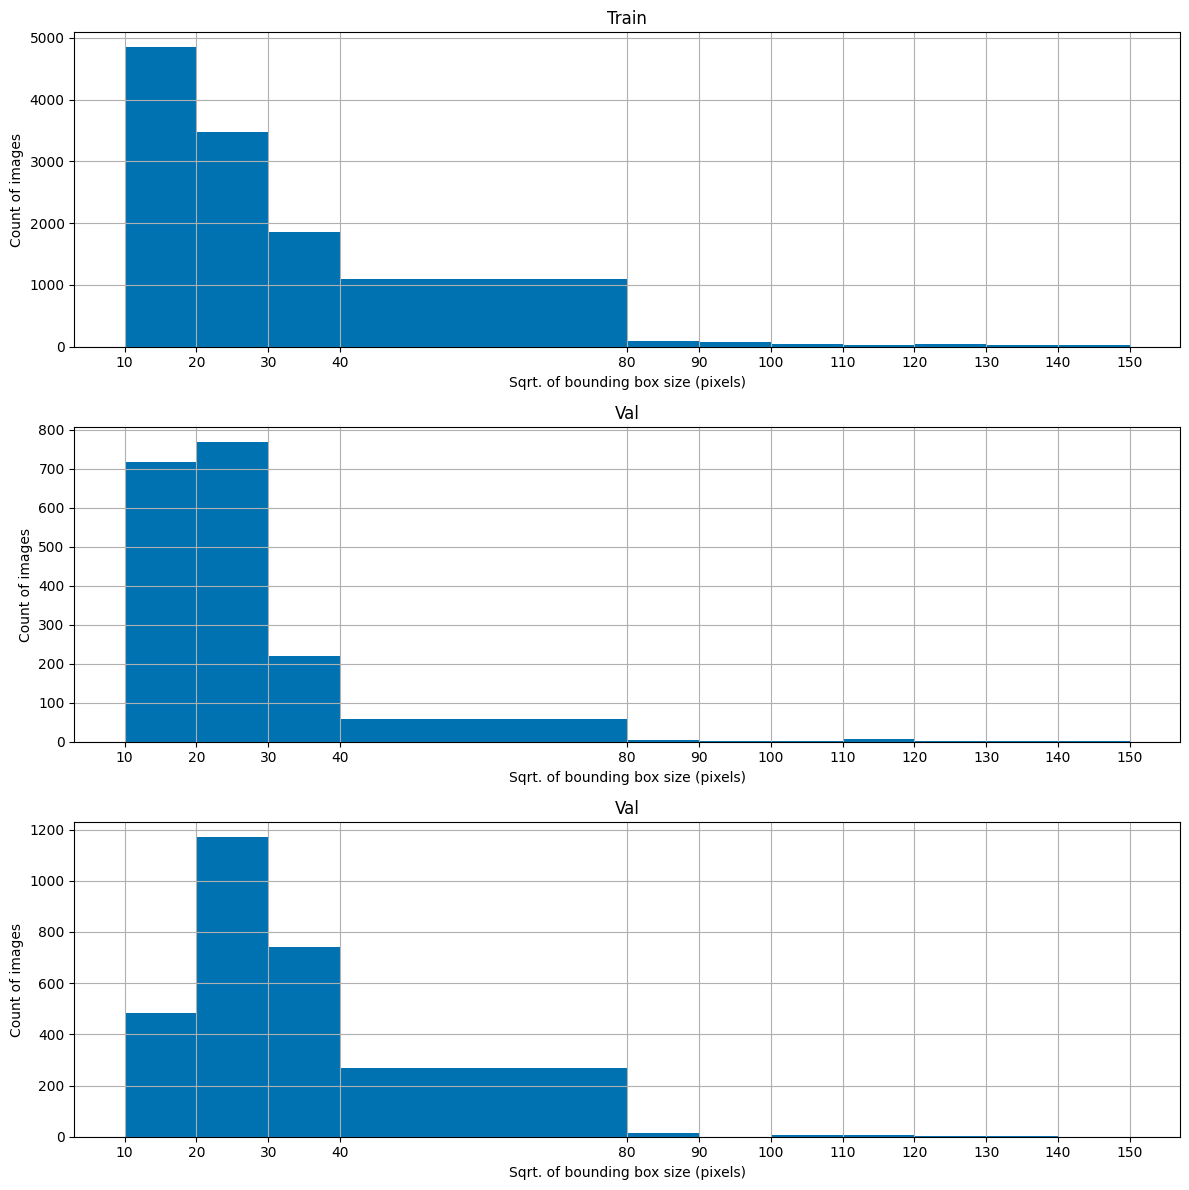

In [127]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Train subplot

values_train = list(image_area_dict_train.values())

axs[0].hist(values_train,bins=[10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[0].set_xticks([10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[0].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[0].set_ylabel('Count of images')
axs[0].set_title('Train')
axs[0].grid()


# Validation subplot
values_val = list(image_area_dict_val.values())

axs[1].hist(values_val,bins=[10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[1].set_xticks([10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[1].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[1].set_ylabel('Count of images')
axs[1].set_title('Val')
axs[1].grid()

# Test subplot
values_test = list(image_area_dict_test.values())

axs[2].hist(values_test,bins=[10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[2].set_xticks([10, 20, 30, 40,80,90,100,110,120,130,140,150])
axs[2].set_xlabel('Sqrt. of bounding box size (pixels)')
axs[2].set_ylabel('Count of images')
axs[2].set_title('Val')
axs[2].grid()

plt.tight_layout()
plt.show()

### plot above shows the number of images for which the sqrt. of the area is in a certain bin.

I use this to stratify my data accordingly, taking into account that I need enough training data. Bins are 10-20,20-30,30-40 and 40-80. I choose the limit of 1500 images (30 - 40 has below 2000 images).

Since in the labels file the annotations are described by area, I need to square these values.

In [59]:
# analyze the differences of bounding box sizes within an image
test_dict_val = {}
for ann in labels_val['annotations']:
    image_id = ann['image_id']
    area = round((ann['area'] ** 0.5),0)
    if image_id in test_dict_val:
        test_dict_val[image_id].append(area)
    else:
        test_dict_val[image_id] = [area]
    

In [63]:
max_diffs = {k: max([abs(test_dict_val[k][0] - val) for val in test_dict_val[k][1:]]) if len(test_dict_val[k]) > 1 else 0 for k in test_dict_val}

sorted_max_diffs = dict(sorted(max_diffs.items(), key=lambda x: x[1], reverse=True))

print(sorted_max_diffs)

{560: 82.0, 887: 70.0, 881: 63.0, 949: 63.0, 992: 63.0, 950: 61.0, 882: 58.0, 886: 56.0, 561: 55.0, 563: 54.0, 747: 52.0, 989: 48.0, 476: 46.0, 520: 46.0, 541: 46.0, 454: 44.0, 876: 43.0, 1008: 43.0, 1010: 43.0, 1571: 43.0, 1594: 43.0, 1595: 43.0, 1596: 43.0, 1597: 43.0, 877: 42.0, 1009: 40.0, 746: 37.0, 1004: 37.0, 455: 36.0, 1553: 36.0, 1547: 34.0, 1549: 34.0, 1560: 34.0, 1562: 34.0, 1531: 32.0, 1544: 32.0, 1545: 32.0, 1593: 32.0, 1543: 31.0, 464: 28.0, 528: 28.0, 1548: 28.0, 735: 27.0, 446: 26.0, 470: 26.0, 487: 26.0, 540: 25.0, 544: 25.0, 180: 24.0, 181: 23.0, 275: 23.0, 529: 23.0, 562: 23.0, 764: 23.0, 765: 23.0, 482: 22.0, 649: 22.0, 743: 22.0, 749: 22.0, 750: 22.0, 788: 22.0, 188: 21.0, 485: 21.0, 159: 20.0, 542: 20.0, 755: 20.0, 756: 20.0, 797: 20.0, 182: 19.0, 221: 19.0, 342: 19.0, 526: 19.0, 619: 19.0, 638: 19.0, 716: 19.0, 1770: 19.0, 483: 18.0, 484: 18.0, 615: 18.0, 640: 18.0, 762: 18.0, 872: 18.0, 873: 18.0, 958: 18.0, 90: 17.0, 759: 17.0, 327: 16.0, 329: 16.0, 333: 16.0, 

### stratify labels files for each tower size
area_ranges have to be adapted for the target tower_size

In [93]:
base_path = "/workspace/data"
os.chdir(base_path)

file_names = ["labels_tower_train.json", "labels_tower_val.json", "labels_tower_test.json"]
area_ranges = [(1600,6400)] #,(400, 900),(900,1600),(1600, 6400)]

for file_name in file_names:
    # open the file and load the data
    with open(file_name, "r") as f:
        labels_data = json.load(f)

    # loop through the different area ranges
    for area_range in area_ranges:
        # loop through the annotations and identify image_ids with valid area for one of their annotations
        valid_image_ids = set()
        for ann in labels_data['annotations']:
            if area_range[0] <= ann['area'] <= area_range[1]:
                valid_image_ids.add(ann['image_id'])
        
        #print(area_range[0])

        # filter the images using the valid image_ids
        filtered_images = []
        for img in labels_data['images']:
            if img['id'] in valid_image_ids:
                filtered_images.append(img)

        # replace the original images list with the filtered one
        labels_data['images'] = filtered_images
        
        for image in labels_data['images'][:]:
            if image['file_name'].startswith('ME'):
                labels_data['images'].remove(image)

        for image in labels_data['images'][:]:
            if image['file_name'].startswith('SU'):
                labels_data['images'].remove(image)

        for image in labels_data['images'][:]:
            if image['file_name'].startswith('CH'):
                labels_data['images'].remove(image)

        # Create a set of all image IDs
        image_ids = set(image['id'] for image in labels_data['images'])
        
        #print(len(image_ids))

        # Filter the annotations to keep only those with a valid image ID
        labels_data['annotations'] = [annotation for annotation in labels_data['annotations'] if annotation['image_id'] in image_ids]

        # finally remove annotations which are below the current area range
        labels_data['annotations'] =[annotation for annotation in labels_data['annotations'] if area_range[0] <= annotation['area'] <= area_range[1]]
        low = area_range[0]
        high = area_range[1]
        
        # save the modified data back to the file
        with open(f"/workspace/data/tower_size/{low}{high}_USNZ_{file_name}", "w") as f:
            json.dump(labels_data, f)

1600
1078
1600
88
1600
110


## check the created dicts stratified by size

In [120]:
base_path = "/workspace/data/tower_size"

os.chdir(base_path)

jf = open("100400_labels_tower_train.json")
labels_train = json.load(jf)


jf = open("400900_labels_tower_train.json")
labels_val = json.load(jf)

jf = open("9001600_labels_tower_train.json")
labels_test = json.load(jf)

jf = open("16006400_labels_tower_train.json")
labels_four = json.load(jf)

In [121]:
# Create a dictionary that maps each image_id to its area of the first corresponding annotation
image_area_dict_val = {}
for ann in labels_val['annotations']:
    if ann['image_id'] not in image_area_dict_val:
        image_area_dict_val[ann['image_id']] = ann['area']
        
image_area_dict_train = {}
for ann in labels_train['annotations']:
    if ann['image_id'] not in image_area_dict_train:
        image_area_dict_train[ann['image_id']] = ann['area']
        
image_area_dict_test = {}
for ann in labels_test['annotations']:
    if ann['image_id'] not in image_area_dict_test:
        image_area_dict_test[ann['image_id']] = ann['area']
        
image_area_dict_four = {}
for ann in labels_four['annotations']:
    if ann['image_id'] not in image_area_dict_four:
        image_area_dict_four[ann['image_id']] = ann['area']

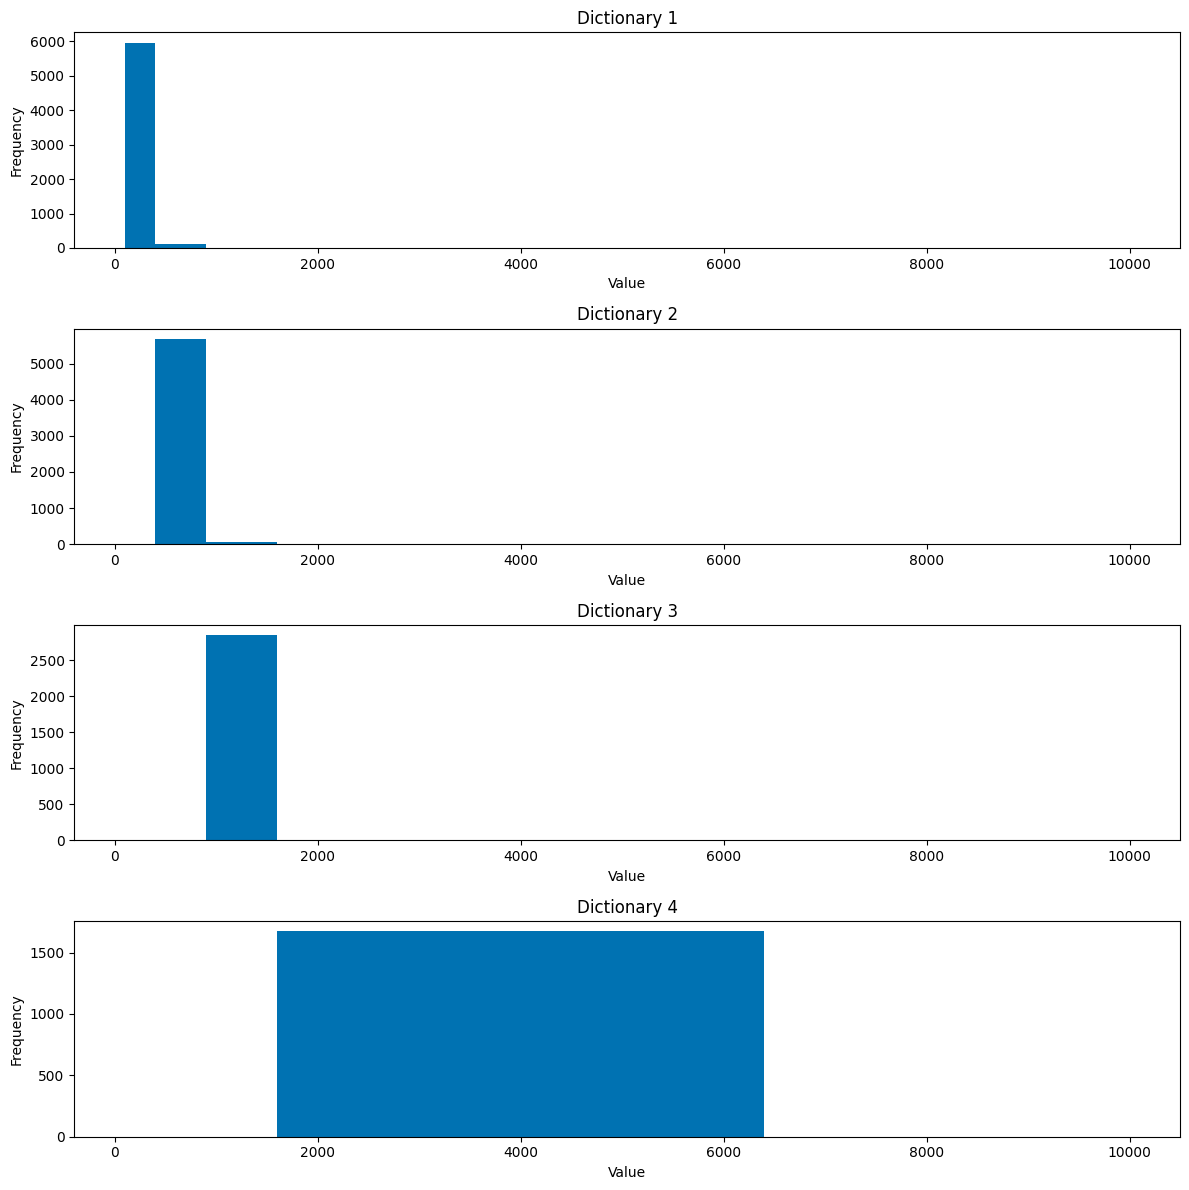

In [122]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,12))

# Loop over the dictionaries and plot a histogram for each one
for i, d in enumerate([image_area_dict_train, image_area_dict_val, image_area_dict_test, image_area_dict_four]):
    # Extract the values from the dictionary
    values = list(d.values())

    # Plot the histogram
    #axes[i].hist(values,bins=[10, 20, 30, 40,80])
    axes[i].hist(values,bins=[100,400,900,1600,6400,10000])

    # Set the title and labels for the subplot
    axes[i].set_title(f"Dictionary {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [3]:
## see how the distribution over country is now

base_path = "/workspace/data/tower_size"
#base_path = "/workspace/data"
os.chdir(base_path)


In [ ]:
# the following plotting function only works for one tower size, needs to be adapted accordingly or extended

In [9]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Load the COCO dictionaries
with open('100400_labels_tower_train.json', 'r') as f:
    train_dict = json.load(f)
    
with open('100400_labels_tower_val.json', 'r') as f:
    val_dict = json.load(f)
    
with open('100400_labels_tower_test.json', 'r') as f:
    test_dict = json.load(f)

    

location_mapping = {'AR': 'USA',
 'CH': 'China', 
 'CL': 'USA', 
 'DU': 'New Zealand', 
 'GI': 'New Zealand', 
 'KA': 'USA', 
 'ME': 'Mexico', 
 'PA': 'New Zealand', 
 'RO': 'New Zealand', 
 'SU': 'Sudan', 
 'TA': 'New Zealand', 
 'WI': 'USA'}

category_dict = {0: 'Distribution', 1: 'Transmission'}    

# Create a dictionary to store the counts by location and category
counts = {}

image_id = None
for dataset, dataset_dict in zip(['train', 'val', 'test'], [train_dict, val_dict, test_dict]):
    # Create a dictionary to map image IDs to file names
    id_to_filename = {img['id']: img['file_name'] for img in dataset_dict['images']}
    for annotation in dataset_dict['annotations']:
        # Get the file name from the image ID in the annotation
        file_name = id_to_filename[annotation['image_id']]
        # Extract the location from the image filepath
        location = location_mapping[file_name[:2]]
        if location not in counts:
            counts[location] = {}
        
        # Extract the category from the annotation
        category_id = annotation['category_id']
        category = category_dict[category_id]
        if category not in counts[location]:
            counts[location][category] = [0, 0, 0]
        
        # Only count the first annotation for each image ID
        if annotation['image_id'] != image_id:
            image_id = annotation['image_id']
            # Increment the count for the appropriate split
            if dataset == 'train':
                counts[location][category][0] += 1
            elif dataset == 'val':
                counts[location][category][1] += 1
            elif dataset == 'test':
                counts[location][category][2] += 1

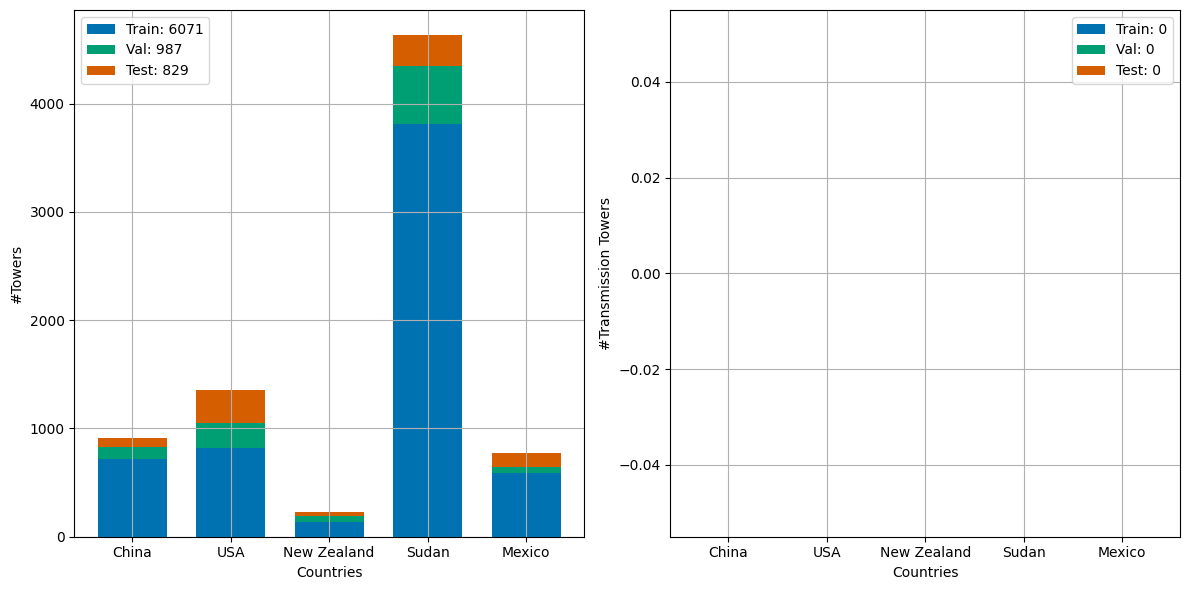

In [10]:
# Get the country names and the data for each category
countries = list(counts.keys())
distribution_data = [counts[c]['Distribution'] for c in countries]
transmission_data = [counts[c]['Transmission'] if 'Transmission' in counts[c] else [0,0,0] for c in countries]

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
index = np.arange(len(countries))
bar_width = 0.7
totals = {'transmission':{}, 'distribution':{}}
# Plot the distribution data
bottom = [0] * len(countries)

for i, mode in enumerate(['Train', 'Val', 'Test']):
    
    y = [d[i] for d in distribution_data]
    totals['distribution'][mode] = sum(y)
    ax1.bar(index, y, bar_width, bottom=bottom, label=mode)
    bottom = [bottom[j] + distribution_data[j][i] for j in range(len(countries))]
    
ax1.set_xlabel('Countries')
ax1.set_ylabel('#Towers')
ax1.set_xticks(index)
ax1.set_xticklabels(countries)
ax1.legend([f"Train: {totals['distribution']['Train']}",
           f"Val: {totals['distribution']['Val']}", 
           f"Test: {totals['distribution']['Test']}"])
ax1.grid()

# # Plot the transmission data
# bottom = [0] * len(countries)
# for i, mode in enumerate(['Train', 'Val', 'Test']):
#     y = [d[i] for d in transmission_data]
#     totals['transmission'][mode] = sum(y)
    
#     ax2.bar(index, y, bar_width, bottom=bottom, label=mode)
#     bottom = [bottom[j] + transmission_data[j][i] for j in range(len(countries))]
        
# ax2.set_xlabel('Countries')
# ax2.set_ylabel('#Transmission Towers')
# ax2.set_xticks(index)
# ax2.set_xticklabels(countries)
# ax2.legend([f"Train: {totals['transmission']['Train']}",
#            f"Val: {totals['transmission']['Val']}", 
#            f"Test: {totals['transmission']['Test']}"])
# ax2.grid()

plt.tight_layout()
plt.show()

## check statistics of the distributions for both tower types

In [96]:
base_path = "/workspace/data"

os.chdir(base_path)

jf = open("labels_train_DT.json")
labels_dt = json.load(jf)

jf = open("labels_train_TT.json")
labels_tt = json.load(jf)


In [97]:
areas_dt = [ann['area'] for ann in labels_dt['annotations']]
max_area_dt = max(areas_dt)
min_area_dt = min(areas_dt)
avg_area_dt = statistics.mean(areas_dt)
med_area_dt = statistics.median(areas_dt)
mode_area_dt = statistics.mode(areas_dt)
var_area_dt = statistics.variance(areas_dt)


print(f"Minimum area: {min_area_dt}")
print(f"Maximum area: {max_area_dt}")
print(f"Average area: {avg_area_dt}")

print(f"Median area: {med_area_dt}")
print(f"Mode area: {mode_area_dt}")
print(f"Variance of areas: {var_area_dt}")


Minimum area: 36.0
Maximum area: 17880.0
Average area: 472.53781465176655
Median area: 300.0
Mode area: 180.0
Variance of areas: 298904.8075648138


In [99]:
areas_tt = [ann['area'] for ann in labels_tt['annotations']]
max_area_tt = max(areas_tt)
min_area_tt = min(areas_tt)
avg_area_tt = statistics.mean(areas_tt)
med_area_tt = statistics.median(areas_tt)
mode_area_tt = statistics.mode(areas_tt)
var_area_tt = statistics.variance(areas_tt)


print(f"Minimum area: {min_area_tt}")
print(f"Maximum area: {max_area_tt}")
print(f"Average area: {avg_area_tt}")
print(f"Median area: {med_area_tt}")
print(f"Mode area: {mode_area_tt}")
print(f"Variance of areas: {var_area_tt}")

Minimum area: 187.0
Maximum area: 44980.0
Average area: 6491.196325459317
Median area: 4920.0
Mode area: 3496.0
Variance of areas: 42585176.94042767
